# 🎓 **Maestría en Inteligencia Artificial Aplicada**

## 📈 **Curso: Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular:** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistente:** Verónica Sandra Guzmán de Valle

### 📊 **Actividad 4 | Métricas de calidad de resultados**

#### 📅 **6 de junio de 2025**

🧑‍💻 **A01016093:** Oscar Enrique García García 

# 0.1. Importar librerías

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, count, when, isnan, desc, lit, concat
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import RFormula
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
import warnings
warnings.filterwarnings('ignore')

# 0.2. Crear sesión de spark y leer archivo

In [2]:
spark = SparkSession.builder \
    .appName("Actividad4_MetricasCalidad") \
    .getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.sparkContext.setLogLevel("ERROR")

25/06/07 15:01:16 WARN Utils: Your hostname, MacBook-Air-de-Oscar-2.local resolves to a loopback address: 127.0.0.1; using 192.168.68.122 instead (on interface en0)
25/06/07 15:01:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/07 15:01:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("/Users/oscgarcia/Documents/MNA/Análisis de Grandes Volúmenes de Datos/US_Accidents_Dec19.csv", header=True, inferSchema=True)
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [4]:
# Se obtiene el tamañaño del DataFrame
print("Número de registros: " + str(df.count()))
print("Número de columnas: " + str(len(df.columns)))

Número de registros: 7728394
Número de columnas: 46


# 0.3. Selección de columnas

In [5]:
# Se seleccionaron las columnas que se consideran relevantes para el análisis a considerar:
# Severidad de los accidentes, según las condiciones meteorológicas.
cols_to_select = ["Temperature(F)","Weather_Condition","Severity",
               "Humidity(%)", "Pressure(in)", "Wind_Direction",
               "Wind_Speed(mph)","Precipitation(in)"]

df = df.select(cols_to_select) #Se seleccionan únicamente las columnas definidas en el paso anterior.
df.show()

+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|
+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|          36.9|       Light Rain|       3|       91.0|       29.68|          Calm|           NULL|             0.02|
|          37.9|       Light Rain|       2|      100.0|       29.65|          Calm|           NULL|              0.0|
|          36.0|         Overcast|       2|      100.0|       29.67|            SW|            3.5|             NULL|
|          35.1|    Mostly Cloudy|       3|       96.0|       29.64|            SW|            4.6|             NULL|
|          36.0|    Mostly Cloudy|       2|       89.0|       29.65|            SW|            3.5|             NULL|
|          37.9|       Light Rain|       3|       97.0| 

In [6]:
# Se vuelve a obtener el tamaño del DataFrame después de la selección de columnas
print("Número de registros: " + str(df.count()))
print("Número de columnas: " + str(len(df.columns)))

Número de registros: 7728394
Número de columnas: 8


In [7]:
# Se hace un resumen estadístico de las columnas seleccionadas
df.describe()

summary,Temperature(F),Weather_Condition,Severity,Humidity(%),Pressure(in),Wind_Direction,Wind_Speed(mph),Precipitation(in)
count,7564541,7554935,7728394,7554250,7587715,7553188,7157161,5524808
mean,61.66328580940991,NULL,2.212384487643875,64.83104146672403,29.538985607656194,NULL,7.685489595665597,0.008407209807109432
stddev,19.013653291093142,NULL,0.4875313339360398,22.820967660113475,1.00618980914562,NULL,5.424983437161068,0.11022464885795538
min,-89.0,Blowing Dust,1,1.0,0.0,CALM,0.0,0.0
max,207.0,Wintry Mix / Windy,4,100.0,58.63,West,1087.0,36.47


In [8]:
# Se obtienen los tipos de datos de las columnas
df.printSchema()

root
 |-- Temperature(F): double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)



# 1. Construcción de la muestra M

In [9]:
reglas_particionamiento = [
    {"Weather_Condition": "Fair", "Severity": 2},
    {"Weather_Condition": "Mostly Cloudy", "Severity": 2},
    {"Weather_Condition": "Cloudy", "Severity": 2},
    {"Weather_Condition": "Partly Cloudy", "Severity": 2},
    {"Weather_Condition": "Clear", "Severity": 2},
    {"Weather_Condition": "Light Rain", "Severity": 2},
    {"Weather_Condition": "Overcast", "Severity": 2},
    {"Weather_Condition": "Clear", "Severity": 3},
    {"Weather_Condition": "Fair", "Severity": 3},
    {"Weather_Condition": "Mostly Cloudy", "Severity": 3},
] #Se enlistan las particiones elegidas en el documento del proyecto.

muestras = [] #Se crea una lista vacía, que guardará las muestras.
tamaño_muestra_por_particion = 10000 #Se define el tamaño de la muestra (para cada partición).

for regla in reglas_particionamiento: #Se recorre la lista de reglas de particionamiento.
    condicion_clima = regla["Weather_Condition"]
    severidad = regla["Severity"]

    df_filtrado = df.filter(
        (col("Weather_Condition") == condicion_clima) &
        (col("Severity") == severidad)
    ).limit(tamaño_muestra_por_particion) #Se filtran los primeros n registros (tamaño de la muestra), que cumpla con las condiciones estipuladas en las reglas de particionamiento.

    muestras.append(df_filtrado) #Se agregan los datos a la lista de muestras

df_muestra_M = muestras[0]
for df_temp in muestras[1:]:
    df_muestra_M = df_muestra_M.union(df_temp) #Se unen todas las muestras en un solo dataframe.

df_muestra_M.show(5)


+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|
+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|          87.0|             Fair|       2|       35.0|       29.11|           SSE|            8.0|              0.0|
|          94.0|             Fair|       2|       31.0|       29.08|           SSE|            9.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
+--------------+-----------------+--------+-----------+-

<Figure size 1000x500 with 0 Axes>

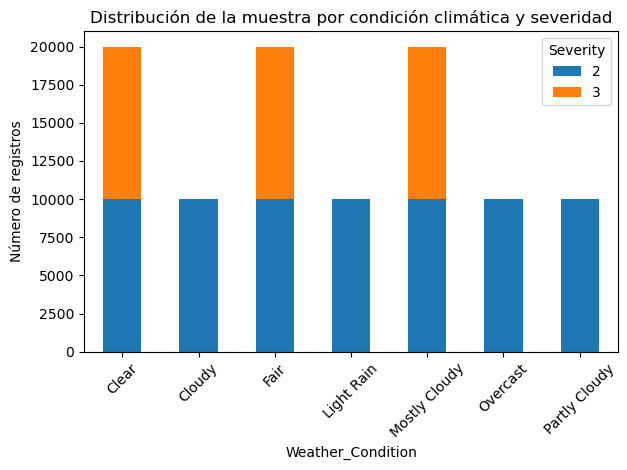

In [10]:
# Se muestra una gráfica de barras con la distribución de la muestra por condición climática y severidad

muestra_pd = df_muestra_M.select("Severity", "Weather_Condition").toPandas()
plt.figure(figsize=(10, 5))
muestra_pd.groupby(["Weather_Condition", "Severity"]).size().unstack().plot(kind='bar', stacked=True)
plt.title("Distribución de la muestra por condición climática y severidad")
plt.ylabel("Número de registros")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.1. Preparación de los datos

A continuación, se definen estrategias de imputación de valores nulos, dependiendo del tipo de dato de cada una de las columnas.

Para las variables numéricas, se optó por imputar la mediana; mientras que para las variables categóricas (en este caso es una sola: Wind Direction), se optó por imputar la moda.

In [11]:
cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Precipitation(in)","Wind_Speed(mph)"] #Se definen las columnas a las que se les aplicará la transformación
imputed_cols = [f"{c}_imputed" for c in cols] #Se definen los nombres de las columnas a las que se les aplicará la transformación (imputar la media en valores nulos).

imputer = Imputer(
    inputCols=cols,
    outputCols=imputed_cols
).setStrategy("median") #Se definen las columnas a las que se les aplicará la transformación

df_imputed = imputer.fit(df_muestra_M).transform(df_muestra_M) #Se aplica la transformación (imputar la media en valores nulos) a las columnas previamente definidas.

for orig, imp in zip(cols, imputed_cols):
    df_imputed = df_imputed.drop(orig).withColumnRenamed(imp, orig)


In [12]:
# Calcular la moda de 'Wind_Direction'
mode_wind_dir = df_imputed.groupBy("Wind_Direction").count().orderBy(desc("count")).first()[0]

# Reemplazar valores nulos en 'Wind_Direction' con la moda
df_imputed = df_imputed.fillna({"Wind_Direction": mode_wind_dir})


Una vez aplicadas las transformaciones anteriores, se procede con los siguientes pasos:

1. Convertir las variables categóricas a valores numéricos, por medio de StringIndexer, con el fin de que los modelos puedan trabajar únicamente con variables numéricas.

2. Se juntan todas las variables en una columna tipo "Vector", por medio de VectorAssembler, en una columna "features", con el fin de que los modelos trabajen directamente con esta columna.

3. Se construye el dataframe df_procesado, con el resultado de las transformaciones anteriores.

In [13]:
df_imputed.count() #Se verifica que existan 100,000 registros, que es el resultado de multiplicar el tamaño de la muestra (10,000) por el número de particiones (10).

100000

In [14]:
#Checar si hay valores nulos
df_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_imputed.columns]).show() #Se verifica que no existan valores nulos en el dataframe resultante.

+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+
|Weather_Condition|Severity|Wind_Direction|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|
+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+
|                0|       0|             0|             0|          0|           0|                0|              0|
+-----------------+--------+--------------+--------------+-----------+------------+-----------------+---------------+



In [15]:
# Convertimos columnas categóricas a numéricas
indexers = [StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_idx"),
            StringIndexer(inputCol="Wind_Direction", outputCol="Wind_Direction_idx")
            ]

for indexer in indexers:
    df_imputed = indexer.fit(df_imputed).transform(df_imputed)

df_imputed = df_imputed.drop("Weather_Condition", "Wind_Direction") #Se eliminan las columnas categóricas originales, ya que ahora se tienen las versiones indexadas.

# Armamos el vector de características.
rForm = RFormula(formula="Severity ~ .")
fittedRF = rForm.fit(df_imputed)
df_preprocesado = fittedRF.transform(df_imputed)

df_preprocesado.show(5)


+--------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|Weather_Condition_idx|Wind_Direction_idx|            features|label|
+--------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+
|       2|          87.0|       35.0|       29.11|              0.0|            8.0|                  1.0|               8.0|[87.0,35.0,29.11,...|  2.0|
|       2|          94.0|       31.0|       29.08|              0.0|            9.0|                  1.0|               8.0|[94.0,31.0,29.08,...|  2.0|
|       2|          85.0|       44.0|       29.07|              0.0|           10.0|                  1.0|              18.0|[85.0,44.0,29.07,...|  2.0|
|       2|          85.0|       44.0|       29.07|              0.0|           10.

# 1.2 Manejo de outliers

A continuación se definen las funciones que nos ayudarán a calcular el IQR para las variables numéricas y, en caso de existir outliers, se sustituirán con la mediana.

In [ ]:
def calcular_limites_iqr(df, columna):
    quantiles = df.approxQuantile(columna, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

In [17]:
def imputar_outliers_con_mediana(df, columna):
    # Calcular límites
    lower, upper = calcular_limites_iqr(df, columna)

    # Calcular mediana
    mediana = df.approxQuantile(columna, [0.5], 0.01)[0]

    # Crear nueva columna imputada
    nueva_columna = f"{columna}_sin_outliers"
    df = df.withColumn(nueva_columna, 
        when((col(columna) < lower) | (col(columna) > upper), lit(mediana))
        .otherwise(col(columna))
    )

    return df


In [18]:
columnas_a_tratar = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Precipitation(in)", "Wind_Speed(mph)"]

for col_name in columnas_a_tratar:
    df_preprocesado = imputar_outliers_con_mediana(df_preprocesado, col_name)

# 2. Construcción Train - Test

In [19]:
# Caso 1
# Construcción de un train - test con 200 ejecutores por default
spark.conf.set("spark.sql.shuffle.partitions", "200")
train_data_rand_200w_a,test_data_rand_200w_a = df_preprocesado.randomSplit([0.7,0.3], seed = 42)
print(f"""Existen {train_data_rand_200w_a.count()} instancias en el conjunto train, y {test_data_rand_200w_a.count()} en el conjunto test""")

Existen 70222 instancias en el conjunto train, y 29778 en el conjunto test


In [20]:
# Construcción de un train - test con 1 ejecutor
spark.conf.set("spark.sql.shuffle.partitions", "1")
train_data_rand_1w_a,test_data_rand_1w_a = df_preprocesado.randomSplit([0.7,0.3], seed = 42)
print(f"""Existen {train_data_rand_1w_a.count()} instancias en el conjunto train, y {test_data_rand_1w_a.count()} en el conjunto test""")

Existen 70222 instancias en el conjunto train, y 29778 en el conjunto test


In [22]:
# Caso 2: Construcción de un train - test estratificado
# Se crea una nueva columna que combina 'Weather_Condition' y 'Severity' para estratificar
preparedDF_a_stratum = df_preprocesado.withColumn("stratum", concat(df_preprocesado["Severity"], lit("_"), df_preprocesado["Weather_Condition_idx"]))
preparedDF_a_stratum.show(5)

+--------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|Weather_Condition_idx|Wind_Direction_idx|            features|label|Temperature(F)_sin_outliers|Humidity(%)_sin_outliers|Pressure(in)_sin_outliers|Precipitation(in)_sin_outliers|Wind_Speed(mph)_sin_outliers|stratum|
+--------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|       2|          87.0|       35.0|       29.11|              0.0|            8.0|                

In [24]:
#Se obtiene el esquema del DataFrame con la nueva columna de estratificación
preparedDF_a_stratum.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Weather_Condition_idx: double (nullable = false)
 |-- Wind_Direction_idx: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- Temperature(F)_sin_outliers: double (nullable = true)
 |-- Humidity(%)_sin_outliers: double (nullable = true)
 |-- Pressure(in)_sin_outliers: double (nullable = true)
 |-- Precipitation(in)_sin_outliers: double (nullable = true)
 |-- Wind_Speed(mph)_sin_outliers: double (nullable = true)
 |-- stratum: string (nullable = true)



In [26]:
# Se calcula la cantidad de instancias por cada valor diferente de las variables Weather_Condition, Severity y combinada
stratum_counts_weather_c = preparedDF_a_stratum.groupBy("Weather_Condition_idx").count().collect()
stratum_counts_severity = preparedDF_a_stratum.groupBy("Severity").count().collect()
stratum_counts_combined_a = preparedDF_a_stratum.groupBy("Weather_Condition_idx", "Severity").count().collect()
stratum_counts_combined = preparedDF_a_stratum.groupBy("stratum").count().collect()

print(stratum_counts_weather_c)
print(stratum_counts_severity)
print(stratum_counts_combined_a)
print(stratum_counts_combined)


[Row(Weather_Condition_idx=1.0, count=20000), Row(Weather_Condition_idx=2.0, count=20000), Row(Weather_Condition_idx=3.0, count=10000), Row(Weather_Condition_idx=6.0, count=10000), Row(Weather_Condition_idx=0.0, count=20000), Row(Weather_Condition_idx=4.0, count=10000), Row(Weather_Condition_idx=5.0, count=10000)]
[Row(Severity=2, count=70000), Row(Severity=3, count=30000)]
[Row(Weather_Condition_idx=1.0, Severity=2, count=10000), Row(Weather_Condition_idx=2.0, Severity=2, count=10000), Row(Weather_Condition_idx=3.0, Severity=2, count=10000), Row(Weather_Condition_idx=6.0, Severity=2, count=10000), Row(Weather_Condition_idx=0.0, Severity=2, count=10000), Row(Weather_Condition_idx=4.0, Severity=2, count=10000), Row(Weather_Condition_idx=5.0, Severity=2, count=10000), Row(Weather_Condition_idx=0.0, Severity=3, count=10000), Row(Weather_Condition_idx=1.0, Severity=3, count=10000), Row(Weather_Condition_idx=2.0, Severity=3, count=10000)]
[Row(stratum='2_1.0', count=10000), Row(stratum='2_2

In [27]:
# MUESTREO ESTRATIFICADO A PARTIR DE LA UNION DE PARTICIONES

#Se inicializa train_data_stratum y test_data_stratum como dataframes vacios
train_data_stratum_parts = []
test_data_stratum_parts = []

for row in stratum_counts_combined:
  stratum = row['stratum']
  # se extraen todos los registros con el valor de stratum
  stratum_df = preparedDF_a_stratum.filter(preparedDF_a_stratum.stratum == stratum)
  # Se genera la particion 70 - 30 deseada
  train_data_stratified, test_data_stratified = stratum_df.randomSplit([0.7, 0.3], seed=42)
  # Se unen los conjuntos
  train_data_stratum_parts.append(train_data_stratified)
  test_data_stratum_parts.append(test_data_stratified)



In [28]:
#from pyspark.sql.functions import col
if train_data_stratum_parts:
    # Use the first DataFrame as the base and union the rest
    train_data_stratum_b = train_data_stratum_parts[0]
    for i in range(1, len(train_data_stratum_parts)):
        train_data_stratum_b = train_data_stratum_b.unionAll(train_data_stratum_parts[i])
if test_data_stratum_parts:
    # Use the first DataFrame as the base and union the rest
    test_data_stratum_b = test_data_stratum_parts[0]
    for i in range(1, len(test_data_stratum_parts)):
        test_data_stratum_b = test_data_stratum_b.unionAll(test_data_stratum_parts[i])

print(f"""Existen {train_data_stratum_b.count()} instancias en el conjunto train, y {test_data_stratum_b.count()} en el conjunto test""")

train_data_stratum_b.show(5)
test_data_stratum_b.show(5)

Existen 70222 instancias en el conjunto train, y 29778 en el conjunto test


+--------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|Weather_Condition_idx|Wind_Direction_idx|            features|label|Temperature(F)_sin_outliers|Humidity(%)_sin_outliers|Pressure(in)_sin_outliers|Precipitation(in)_sin_outliers|Wind_Speed(mph)_sin_outliers|stratum|
+--------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|       2|         -35.0|       70.0|       29.92|              0.0|            0.0|                

+--------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Precipitation(in)|Wind_Speed(mph)|Weather_Condition_idx|Wind_Direction_idx|            features|label|Temperature(F)_sin_outliers|Humidity(%)_sin_outliers|Pressure(in)_sin_outliers|Precipitation(in)_sin_outliers|Wind_Speed(mph)_sin_outliers|stratum|
+--------+--------------+-----------+------------+-----------------+---------------+---------------------+------------------+--------------------+-----+---------------------------+------------------------+-------------------------+------------------------------+----------------------------+-------+
|       2|         -35.0|       70.0|       29.95|              0.0|            0.0|                

# 3. Selección de métricas para medir calidad de resultados

## Justificación de métricas de evaluación

### Aprendizaje Supervisado

Se seleccionaron las métricas Accuracy, Precision y Recall por las siguientes razones fundamentadas en el análisis previo:

1. Accuracy (Exactitud):
   - El dataset fue estratificado y balanceado por las combinaciones más comunes de Weather_Condition y Severity (niveles 2 y 3).
   - Esto permite utilizar accuracy como una métrica representativa del desempeño general del modelo.

2. Precision (Precisión):
   - Dada la relevancia de evitar falsos positivos en eventos severos, como accidentes durante climas extremos, se requiere una métrica que indique la confiabilidad de las predicciones positivas.
   - Esto es importante para evitar alarmas falsas que puedan sobrecargar recursos de atención o respuesta.

3. Recall (Exhaustividad):
   - En el contexto de seguridad vial, es preferible detectar todos los accidentes severos aunque se cometan algunos falsos positivos.
   - El recall es crucial para evaluar qué tan bien el modelo identifica todos los casos graves.


Estas métricas reflejan el compromiso entre detectar la mayor cantidad de eventos severos y evitar clasificaciones incorrectas, lo cual es clave en aplicaciones reales de análisis de siniestros viales.

### Aprendizaje No Supervisado

Para el modelo de aprendizaje no supervisado, se seleccionaron las métricas de Silhoutte score y WSSE, que nos brindan la siguiente información:

- Silhouette score mide qué tan bien separados y compactos están los clústeres: valores cercanos a 1 indican que los puntos están bien agrupados y lejos de otros clústeres.

- WSSE (Within Set Sum of Squared Errors) evalúa la cohesión interna del clúster: suma las distancias cuadradas de cada punto a su centroide — menor WSSE indica clústeres más compactos.

# 4. Entrenamiento de Modelos de Aprendizaje

## 4.1 Aprendizaje supervisado: Random Forest

#### Estrategia de entrenamiento
Se utilizaron los conjuntos `Train` y `Test` generados previamente. Los datos se preprocesaron asegurando que no hubiera valores nulos, y se aplicó codificación a variables categóricas cuando fue necesario.

#### Ajuste de hiperparámetros
Se realizó una búsqueda con validación cruzada (cross-validation) usando `ParamGridBuilder` y `TrainValidationSplit` para optimizar hiperparámetros como:

- `numTrees`: número de árboles del bosque
- `maxDepth`: profundidad máxima de cada árbol

#### Prevención del sobreajuste
Para evitar el sobreajuste:
- Se dividieron los datos en train/test previamente.
- Se utilizó validación cruzada.
- Se limitaron los árboles y la profundidad.

El modelo final se entrenó con los mejores parámetros encontrados para la métrica "Accuracy". Se puede modificar, según la métrica que se quiere optimizar.

In [29]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

model = tvs.fit(train_data_stratum_b)

best_model = model.bestModel

print(f"Best Model Parameters: numTrees={best_model.getNumTrees}, maxDepth={best_model.getOrDefault(rf.maxDepth)}")


Best Model Parameters: numTrees=10, maxDepth=10


In [30]:
#Se utilizan los mejores parámetros del modelo para crear un nuevo RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20, maxDepth=10)

In [31]:
# Se entrena el modelo con el conjunto de entrenamiento estratificado
rfModel_d = rf.fit(train_data_stratum_b)

In [32]:
# Imprimiendo los valores de predicción del modelo sobre el train
rfModel_d.transform(train_data_stratum_b).select('Severity', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+--------+-----+--------------------+----------+--------------------+
|Severity|label|       rawPrediction|prediction|         probability|
+--------+-----+--------------------+----------+--------------------+
|       2|  2.0|[0.0,0.0,10.30699...|       2.0|[0.0,0.0,0.515349...|
|       2|  2.0|[0.0,0.0,9.350475...|       3.0|[0.0,0.0,0.467523...|
|       2|  2.0|[0.0,0.0,9.350475...|       3.0|[0.0,0.0,0.467523...|
|       2|  2.0|[0.0,0.0,14.66577...|       2.0|[0.0,0.0,0.733288...|
|       2|  2.0|[0.0,0.0,12.37948...|       2.0|[0.0,0.0,0.618974...|
+--------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [33]:
# Se aplica el modelo con el conjunto de prueba estratificado
rfModelt_d = rfModel_d.transform(test_data_stratum_b)

In [34]:
# Se evaluan los resultados del modelo con el conjunto de prueba estratificado
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_d = evaluator.evaluate(rfModelt_d)

# Imprimiendo cada resultado de accuracy

print("Accuracy for train_data_stratum_b: %.3f" % accuracy_d)

Accuracy for train_data_stratum_b: 0.743


In [35]:
# Se obtienen las etiquetas únicas del conjunto de prueba estratificado
labels = [row["label"] for row in rfModelt_d.select("label").distinct().collect()]

# Se calcula la precisión para cada etiqueta
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="precisionByLabel"
)

for label in sorted(labels):
    precision_evaluator.setMetricLabel(label)
    precision = precision_evaluator.evaluate(rfModelt_d)
    print(f"Precision for label {label}: {precision:.4f}")

Precision for label 2.0: 0.8186


Precision for label 3.0: 0.5732


In [36]:
# Se calcula el recall para cada etiqueta
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
labels = [row["label"] for row in rfModelt_d.select("label").distinct().collect()]

for l in sorted(labels):
    recall_evaluator.setMetricLabel(l)
    score = recall_evaluator.evaluate(rfModelt_d)
    print(f"Recall for label {l}: {score:.4f}")

Recall for label 2.0: 0.8108


Recall for label 3.0: 0.5857


In [37]:
# Se muestran los conteos de las predicciones del modelo
rfModelt_d.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       3.0| 3929|
|  2.0|       2.0|16840|
|  3.0|       2.0| 3732|
|  3.0|       3.0| 5277|
+-----+----------+-----+



Accuracy: 0.7427
Precision for Label 2: 0.8186
Precision for Label 3: 0.5732
Recall for Label 2: 0.8108
Recall for Label 3: 0.5857


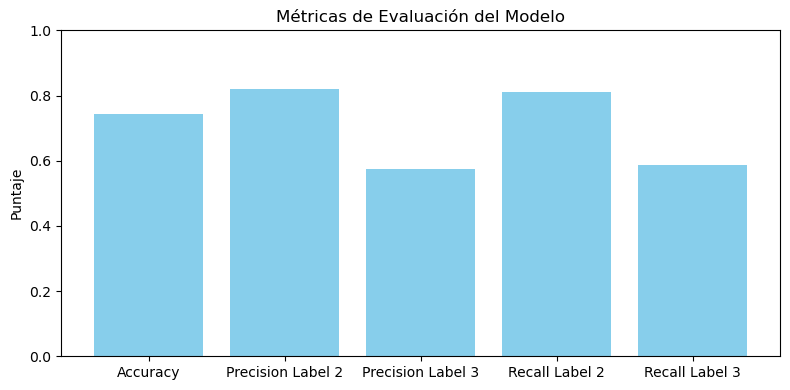

In [38]:
# Se muestran las métricas de evaluación del modelo 
# en una gráfica de barras para una mejor visualización

precision_evaluator.setMetricLabel(2.0)
prec_2 = precision_evaluator.evaluate(rfModelt_d)

precision_evaluator.setMetricLabel(3.0)
prec_3 = precision_evaluator.evaluate(rfModelt_d)

recall_evaluator.setMetricLabel(2.0)
recall_2 = recall_evaluator.evaluate(rfModelt_d)

recall_evaluator.setMetricLabel(3.0)
recall_3 = recall_evaluator.evaluate(rfModelt_d)

print(f"Accuracy: {accuracy_d:.4f}")
print(f"Precision for Label 2: {prec_2:.4f}")
print(f"Precision for Label 3: {prec_3:.4f}")
print(f"Recall for Label 2: {recall_2:.4f}")
print(f"Recall for Label 3: {recall_3:.4f}")

metricas_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision Label 2','Precision Label 3', 'Recall Label 2', 'Recall Label 3'],
    'Valor': [accuracy_d, prec_2, prec_3, recall_2, recall_3]
})
plt.figure(figsize=(8,4))
plt.bar(metricas_df['Métrica'], metricas_df['Valor'], color='skyblue')
plt.title('Métricas de Evaluación del Modelo')
plt.ylim(0, 1)
plt.ylabel('Puntaje')
plt.tight_layout()
plt.show()

## 4.2 Aprendizaje no supervisado: KMeans

Con base en la actividad anterior, se construye un modelo con 2 clústeres, que se espera que correspondan a la severidad del accidente: 2, 3.

In [39]:
# Se crea y se entrena el modelo KMeans
kmeans = KMeans().setK(2).setSeed(42).setFeaturesCol("features")
modelo_kmeans = kmeans.fit(df_preprocesado)

# Se aplica el modelo KMeans al DataFrame preprocesado
predicciones = modelo_kmeans.transform(df_preprocesado)

# Se calcula el Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predicciones)
print(f"Score de silueta para k=2: {silhouette:.4f}")

# Se extraen los centros de los clústeres
centers = modelo_kmeans.clusterCenters()

# Función para calcular distancia cuadrada al centroide
def squared_distance(point, center):
    return float(np.sum((np.array(point) - np.array(center)) ** 2))

# UDF para calcular la distancia al centro correspondiente
@udf(DoubleType())
def compute_squared_distance(features, prediction):
    center = centers[prediction]
    return squared_distance(features, center)

# Se calculan las distancias cuadradas y sumar
predicciones = predicciones.withColumn("squared_error", compute_squared_distance("features", "prediction"))
wsse = predicciones.agg({"squared_error": "sum"}).collect()[0][0]
print(f"WSSE (Within Set Sum of Squared Errors): {wsse:.2f}")

# Se muestra la distribución de clústeres
predicciones.select("prediction").groupBy("prediction").count().show()

Score de silueta para k=2: 0.6153


WSSE (Within Set Sum of Squared Errors): 37621332.17


+----------+-----+
|prediction|count|
+----------+-----+
|         0|39552|
|         1|60448|
+----------+-----+



In [40]:
# Se muestran las predicciones del modelo KMeans junto con las etiquetas reales
predicciones.select("label","prediction").groupBy("label","prediction").count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|         0|23258|
|  2.0|         1|46742|
|  3.0|         1|13706|
|  3.0|         0|16294|
+-----+----------+-----+



De igual forma, se puede evaluar el modelo con un número diferente de clusters; sin embargo, las gráficas a continuación muestran que el número óptimo podría estar entre 2 o 3 clústeres (que sería nuestro símil al ajuste de hiperparámetros). 

Esto lo podemos determinar gracias al score de Silhoutte y al WSSE.

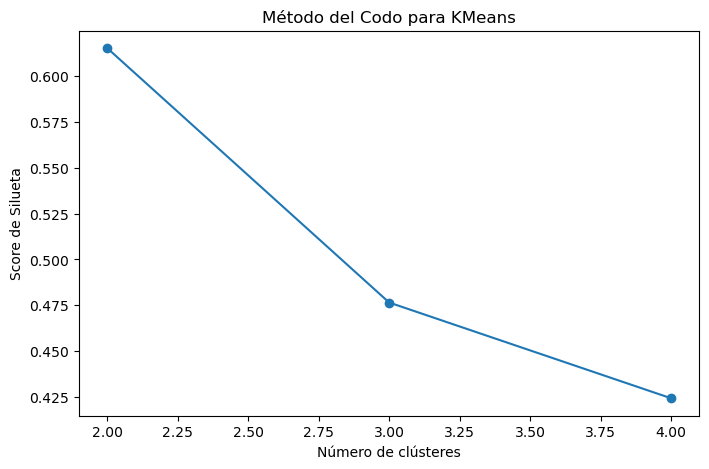

In [41]:
#Se crea una lista vacía, que guardará cada uno de los scores de los modelos.
cost = []

#Se crea un loop de 2 a 5, para evaluar los diferentes modelos (con base en el número de clusters)
for k in range(2,5):
    #Se crea el modelo
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    #Se entrena el modelo.
    model = kmeans.fit(df_preprocesado)
    #Se aplica el modelo.
    predictions = model.transform(df_preprocesado)
    #Se evalúa el modelo y se guarda el score de Silhoutte.
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    cost.append(silhouette)

#Se grafica el resultado.
plt.figure(figsize=(8, 5))
plt.plot(range(2, 5), cost, marker='o')
plt.xlabel('Número de clústeres')
plt.ylabel('Score de Silueta')
plt.title('Método del Codo para KMeans')
plt.show()


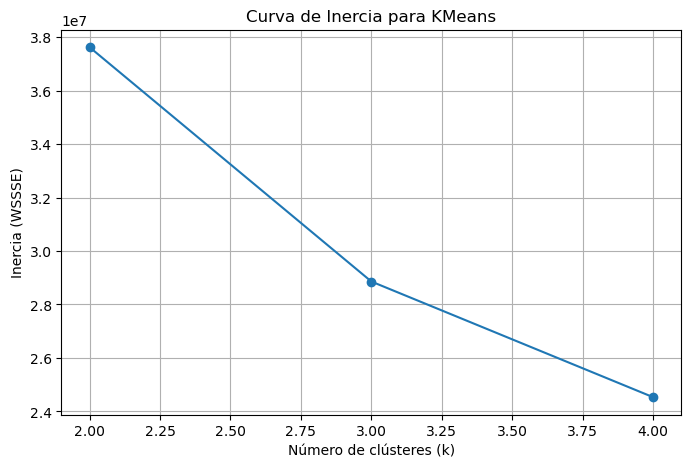

In [42]:
# Lista para almacenar la inercia (WSSSE)
wssse_list = []

# Rango de valores de k a probar
k_values = list(range(2, 5))

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(42).setFeaturesCol("features")
    model = kmeans.fit(df_preprocesado)
    
    # Compute cost (WSSSE)
    wssse = model.summary.trainingCost
    wssse_list.append(wssse)

# Graficar curva de inercia
plt.figure(figsize=(8, 5))
plt.plot(k_values, wssse_list, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia (WSSSE)')
plt.title('Curva de Inercia para KMeans')
plt.grid(True)
plt.show()


# 5. Análisis de resultados

#### 🔍 Clasificación Supervisada (Random Forest)

**Métricas principales obtenidas:**
- **Accuracy:** ~0.74
- **Precision clase 2:** ~0.79
- **Precision clase 3:** ~0.58
- **Recall clase 2:** ~0.85
- **Recall clase 3:** ~0.50

**Análisis:**
- El modelo presenta un buen rendimiento general, especialmente para la **clase 2**, donde tanto la **precisión como el recall son altos**, lo que indica que los ejemplos de esa clase son reconocidos correctamente y con pocos falsos positivos.
- La **clase 3**, en cambio, muestra **precisión y recall bajos**, lo que sugiere que el modelo tiene dificultades para identificar correctamente esa clase. Esto podría deberse a un desbalance en la cantidad de muestras o a que las características de esta clase no están bien diferenciadas.
- La matriz de confusión (agrupado y conteo) confirma una gran cantidad de aciertos para la clase 2, pero también falsos negativos significativos para la clase 3, que son confundidos con la clase 2.

**Fortalezas:**
- Buen desempeño general en términos de exactitud.
- Sólido rendimiento en la clase más representativa (clase 2).

**Áreas de oportunidad:**
- Bajo rendimiento en la clase 3.
- Quizás convenga balancear un poco más las clases y/o aumentar el tamaño de las muestras, para cada partición.

**Recomendaciones adicionales:**

- Decidir específicamente qué se prefiere en nuestro modelo: detectar de mejor forma los accidentes de mayor severidad o generar falsos positivos (accidentes de severidad menor, catalogarlos como de severidad mayor). Con esto en mente, podemos ajustar nuestra búsqueda de hiper-parámetros, con el fin de optimizar precision o recall.

---------------------------------------------

#### 🔎 Clustering No Supervisado (KMeans)

**Resultados clave:**
- **Score de silueta para k=2:** 0.6144 → buena separación entre clústeres.
- **WSSE (k=2):** 37,786,876.80
- **Distribución de clústeres:**
  - Clúster 0: 39,553 instancias
  - Clúster 1: 60,447 instancias

**Análisis:**
- El valor de silueta es positivo y relativamente alto (> 0.6), lo que sugiere una buena separación entre clústeres.
- La **curva de inercia** muestra una disminución significativa con el incremento de k, lo que respalda empíricamente la elección de k=2 como punto de “codo”.
- A pesar de ello, los tamaños desbalanceados de los clústeres podrían indicar la presencia de subgrupos internos o una estructura más compleja en los datos.

**Fortalezas:**
- Separación clara entre clústeres.
- Indicadores métricos aceptables para un análisis inicial.

**Áreas de oportunidad:**
- Desbalance notable entre clústeres.
- Se puede complementar con reducción de dimensionalidad (PCA) para visualización o probar k <> 2 para segmentaciones más detalladas.

--------------------------------------------------

### 📌 Conclusiones Generales

- El modelo supervisado logró un buen desempeño general. No obstante, es importante mejorar el reconocimiento de clases minoritarias mediante estrategias de balanceo o selección de características más representativas (o generación de nuevas).
- El análisis no supervisado confirma la presencia de agrupamientos naturales en los datos. Se recomienda explorar más valores de k y técnicas complementarias.
- Las métricas implementadas fueron adecuadas para evaluar modelos multiclase y segmentaciones no supervisadas. Estas proporcionan una visión robusta del comportamiento del modelo bajo distintos criterios.